In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dr-patient/Live DR-Patient Conversations.wav
/kaggle/input/dr-patient/Live DR-Patient Conversations.json


# Mutilingual Speech Recognition for Clinical Note Taking


### **Background on Model**

Discovered I could finetune my pretrained model after the first notebook solution. Here, I am leveraging the OpenAI's Whisper model, following this [paper](https://cdn.openai.com/papers/whisper.pdf). Trained on about 680,000 hour dataset from the web, it's an advanced ASR system. It handles various accents, background noise, technical language, and multilingual speech transcription. With its encoder-decorder transformer structure, it processes audio in 30-second chunks, and converts them into texts with high accuracy. It has great zero-shot performance across diverse datasets and makes 50% fewer errors.

[Dataset](https://huggingface.co/datasets/yashtiwari/PaulMooney-Medical-ASR-Data): PaulMooney-Medical-ASR-Data.
- Audio recordings and transcriptions.
- Focus on medical terminologies.
- Available on HuggingFace.
- Open-sourced. 

In [2]:
!pip install --upgrade --quiet pip
!pip install --quiet pip datasets[audio] evaluate transformers jiwer tensorflow tensorboard gradio wandb

import torch
import evaluate
import matplotlib.pyplot as plt 
from IPython.display import Audio
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from datasets import load_dataset, DatasetDict
from huggingface_hub import notebook_login
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor, WhisperForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

### **Loging into Huggingface for easy access to data**

In [3]:
notebook_login()

In [4]:
medical_conversation = DatasetDict()

In [5]:
medical_conversation["train"] = load_dataset("yashtiwari/PaulMooney-Medical-ASR-Data", split="test")
medical_conversation["test"] = load_dataset("yashtiwari/PaulMooney-Medical-ASR-Data", split="train")

README.md:   0%|          | 0.00/653 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/239M [00:00<?, ?B/s]

test-00000-of-00011.parquet:   0%|          | 0.00/376M [00:00<?, ?B/s]

test-00001-of-00011.parquet:   0%|          | 0.00/374M [00:00<?, ?B/s]

test-00002-of-00011.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

test-00003-of-00011.parquet:   0%|          | 0.00/371M [00:00<?, ?B/s]

test-00004-of-00011.parquet:   0%|          | 0.00/371M [00:00<?, ?B/s]

test-00005-of-00011.parquet:   0%|          | 0.00/374M [00:00<?, ?B/s]

test-00006-of-00011.parquet:   0%|          | 0.00/362M [00:00<?, ?B/s]

test-00007-of-00011.parquet:   0%|          | 0.00/368M [00:00<?, ?B/s]

test-00008-of-00011.parquet:   0%|          | 0.00/353M [00:00<?, ?B/s]

test-00009-of-00011.parquet:   0%|          | 0.00/368M [00:00<?, ?B/s]

test-00010-of-00011.parquet:   0%|          | 0.00/381M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/381 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/385 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5895 [00:00<?, ? examples/s]

### **Exploratory Data Analysis**

In [6]:
print(medical_conversation['train'].shape)
print(medical_conversation['test'].shape)

(5895, 5)
(381, 5)


In [7]:
#drop columns we don't need
medical_conversation = medical_conversation.remove_columns(["id", "prompt", "speaker_id"])

In [8]:
audio_sample = medical_conversation["train"][0]["path"]["array"]
sampling_rate = medical_conversation["train"][0]["path"]["sampling_rate"]

Audio(data=audio_sample, rate=sampling_rate)

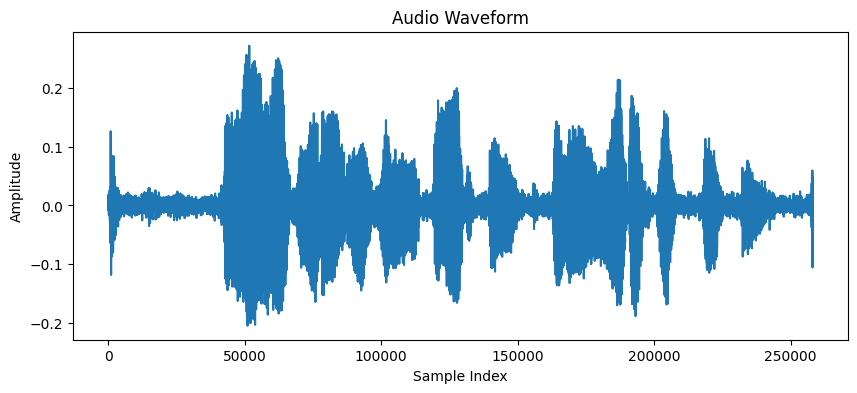

In [9]:
# Plotting the wave form
plt.figure(figsize=(10, 4))
plt.plot(audio_sample)
plt.title("Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

To do our **ASR** we will:
- Extract Features with `WhisperFeatureExtractor`: process the raw audio input.
- Tokenize with `WhisperTokenizer`: post-process model outputs to texts.
- Perform sequence-to-sequence mapping.

In [10]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-medium")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-medium")
processor = WhisperProcessor.from_pretrained("openai/whisper-medium")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

In [11]:
from datasets import Audio
medical_conversation = medical_conversation.cast_column("path", Audio(sampling_rate=16000))

In [12]:
def prepare_dataset(batch):
    
    audio = batch["path"]
    
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    
    return batch

In [13]:
medical_conversation = medical_conversation.map(prepare_dataset, remove_columns=medical_conversation.column_names["train"], num_proc=2)

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/5895 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/381 [00:00<?, ? examples/s]

In [14]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium")

config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

- Input features = transform it into Pytorch tensors.
- Labels = pad to the batch's maximum length. Replace padding tokens by -100 to be removed from loss calculations.

In [15]:
@dataclass
class SpeechSeq2SqWithPadding:
    processor: Any
    decoder_start_token_id: int 

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        # replacing padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch 

In [16]:
data_collator = SpeechSeq2SqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### **Setting up Evaluation Metrics or Validation**

- The evaluate library can give us word_error_rate
- We aim for low wer

In [17]:
metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    label_ids[label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

### **Setting up Training**

In [18]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-dr-patient-conversation",
    per_device_train_batch_size=4, 
    gradient_accumulation_steps=2, 
    learning_rate=1e-5, 
    warmup_steps=50,
    max_steps=500, 
    gradient_checkpointing=True, 
    fp16=True, 
    eval_strategy="steps",  
    per_device_eval_batch_size=8,  
    predict_with_generate=True,  
    generation_max_length=255,  
    save_steps=500,   
    eval_steps=100, 
    logging_steps=50,   
    report_to=["wandb"],  
    load_best_model_at_end=True,   
    metric_for_best_model="wer",  
    greater_is_better=False,   
    push_to_hub=True,   
    run_name="whisper-dr-patient-conversation"
)

In [19]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=medical_conversation["train"],
    eval_dataset=medical_conversation["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

/tmp/ipykernel_60/1922250223.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
max_steps is given, it will override any value given in num_train_epochs


In [20]:
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss,Wer
100,0.665500,0.263961,15.520154
200,0.212600,0.197373,13.540912
300,0.230700,0.150756,19.382090
400,0.146500,0.113202,17.016655
500,0.141000,0.096656,18.030413


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.proce

TrainOutput(global_step=500, training_loss=0.6084648494720459, metrics={'train_runtime': 6506.4414, 'train_samples_per_second': 0.615, 'train_steps_per_second': 0.077, 'total_flos': 4.08241963008e+18, 'train_loss': 0.6084648494720459, 'epoch': 0.6784260515603799})

In [21]:
kwargs = {
    "dataset_tags": "yashtiwari/PaulMooney-Medical-ASR-Data",
    "dataset": "Medical ASR",  
    "model_name": "Whisper Dr Patient Conversation",  
    "finetuned_from": "openai/whisper-medium",
    "tasks": "automatic-speech-recognition",
}
trainer.push_to_hub(**kwargs)

CommitInfo(commit_url='https://huggingface.co/Precillieo/whisper-dr-patient-conversation/commit/f5c18a30db08d0244b74764376abf11f01e8184a', commit_message='End of training', commit_description='', oid='f5c18a30db08d0244b74764376abf11f01e8184a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Precillieo/whisper-dr-patient-conversation', endpoint='https://huggingface.co', repo_type='model', repo_id='Precillieo/whisper-dr-patient-conversation'), pr_revision=None, pr_num=None)

In [22]:
!pip install --quiet pip gradio

from transformers import pipeline
import gradio as gr

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [24]:
pipe = pipeline(model="mahendra0203/whisper-medium-medical") 

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

iface = gr.Interface(
    fn=transcribe, 
    inputs=gr.Audio( type="filepath"), 
    outputs="text",
    title="Multilingual speech recognition for clinical note taking",
    description="Demo of OpenAI Whisper on a dr patient conversation data",
)

iface.launch()

config.json:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://f2d287c34ea4513f99.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
  File "/opt/conda/lib/python3.10/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
  File "/opt/conda/lib/python3.10/site-packages/gradio/blocks.py", line 2043, in process_api
    result = await self.call_function(
  File "/opt/conda/lib/python3.10/site-packages/gradio/blocks.py", line 1590, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/opt/conda/lib/python3.10/site-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "/opt/conda/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 2177, in run_sync_in_worker_thread
    return await future
  File "/opt/conda/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", 